<a href="https://colab.research.google.com/github/SRMannan/Pytorch_L1/blob/main/11_CNN_fashion_mnist_pytorch_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Limitations of Artificial Neural Networks (ANNs)

* **Difficulty with Image Data:**
    * **High dimensionality:** Images are inherently high-dimensional, leading to a large number of input parameters for the network.
    * **Lack of spatial awareness:** Standard ANNs treat input data as a flat vector, losing the crucial spatial relationships between pixels.

    ## How a Basic CNN Works

Convolutional Neural Networks (CNNs) are a type of deep learning neural network specifically designed for processing data with a grid-like topology, such as images. They are inspired by the organization of the animal visual cortex, where small clusters of neurons are sensitive to specific regions of the visual field.

### Key Components of a CNN

* **Convolutional Layers:**
    * **Convolution Operation:** This is the core operation in CNNs. A filter (or kernel) is applied to the input image, sliding across it and computing the dot product between the filter and the underlying region of the image. This produces a feature map, which highlights specific features like edges or textures.
    * **Multiple Filters:** CNNs typically use multiple filters in a single convolutional layer to extract different features.

* **Pooling Layers:**
    * **Downsampling:** Pooling layers reduce the spatial dimensions of the feature maps, making the network more efficient and reducing overfitting.
    * **Common Pooling Types:** Max pooling (selecting the maximum value within a region) and average pooling (averaging the values within a region) are common pooling methods.

* **Fully Connected Layers:**
    * **Classification:** After several convolutional and pooling layers, the feature maps are flattened into a vector and fed into one or more fully connected layers. These layers perform the final classification task, such as assigning a label to an image.

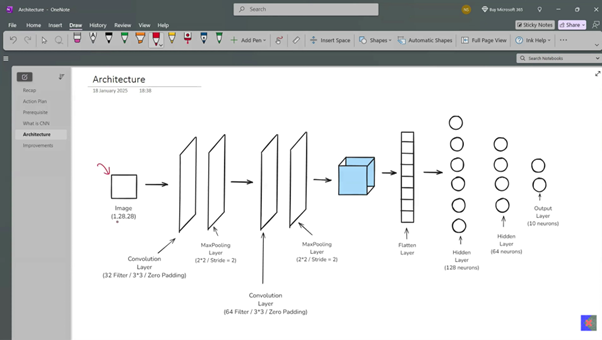

**ARCHI**

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [30]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [31]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [32]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
df.shape

(60000, 785)

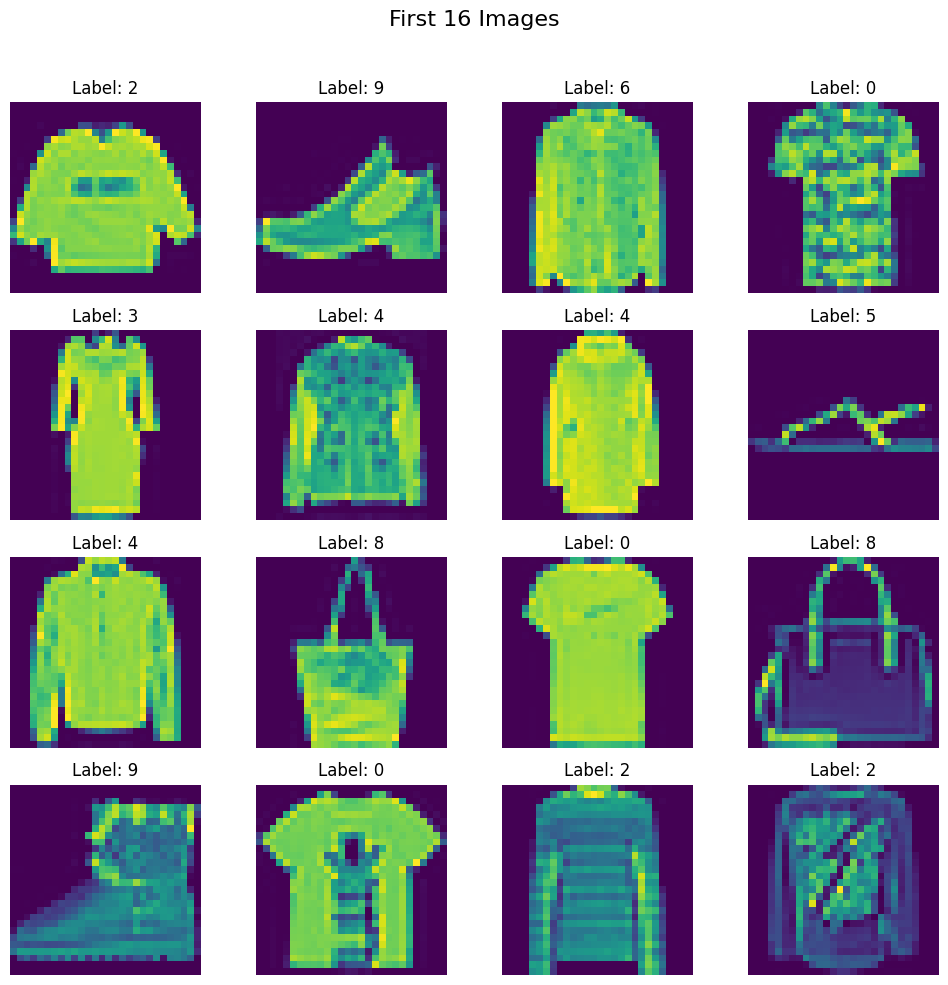

In [34]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [35]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
X_train = X_train/255.0
X_test = X_test/255.0

In [38]:
class CustomDataset(Dataset):

##-------------------CHANGES--------
  def __init__(self, features, labels):

    # Convert to PyTorch tensors
    self.features = torch.tensor(features, dtype=torch.float32).reshape(-1,1,28,28)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [39]:
train_dataset = CustomDataset(X_train, y_train)

In [40]:
test_dataset = CustomDataset(X_test, y_test)

In [41]:
test_dataset

In [42]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [43]:
len(train_loader)

1500

In [44]:
class MyNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)

        return x

In [45]:
learning_rate = 0.1
epochs = 100

In [46]:
# instatiate the model
model = MyNN(1)

#HERE IS THE CHANGE BETWEEN NORMAL AND GPU TRAINING
model.to(device)
# loss function
criterion = nn.CrossEntropyLoss()

## ------------------------------------------------------------------>>>>>>>>
# optimizer with l2 regularisation
optimizer = optim.SGD(model.parameters(), lr=learning_rate , weight_decay = 1e-4)


In [47]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 0.5871391176084677
Epoch: 2 , Loss: 0.4085100576182206
Epoch: 3 , Loss: 0.34881146689504383
Epoch: 4 , Loss: 0.3139030157526334
Epoch: 5 , Loss: 0.28763126452391347
Epoch: 6 , Loss: 0.2617746268088619
Epoch: 7 , Loss: 0.24703567833888035
Epoch: 8 , Loss: 0.2293043869463727
Epoch: 9 , Loss: 0.21770171899721028
Epoch: 10 , Loss: 0.2111867003167669
Epoch: 11 , Loss: 0.1964878127562503
Epoch: 12 , Loss: 0.18654321757269401
Epoch: 13 , Loss: 0.1868305200897157
Epoch: 14 , Loss: 0.1730347143233133
Epoch: 15 , Loss: 0.17175722372469804
Epoch: 16 , Loss: 0.16417457082075998
Epoch: 17 , Loss: 0.15725650343081604
Epoch: 18 , Loss: 0.15304472760809584
Epoch: 19 , Loss: 0.152495824639181
Epoch: 20 , Loss: 0.1468809184076575
Epoch: 21 , Loss: 0.14144213415682316
Epoch: 22 , Loss: 0.136611257328225
Epoch: 23 , Loss: 0.13502624098754798
Epoch: 24 , Loss: 0.13122141270254117
Epoch: 25 , Loss: 0.12663172810610074
Epoch: 26 , Loss: 0.12429874318667378
Epoch: 27 , Loss: 0.118576049896578

In [51]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [52]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(f'ACC : {correct*100/total}%')

ACC : 92.11666666666666%


In [53]:
# evaluation code
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()


print(f'{correct*100/total}%')

99.63333333333334%


**Reduced Gap Between Training and Test Set**